In [1]:
"""
Wine Quality Classification Pipeline
Configurable pipeline for educational purposes
https://archive.ics.uci.edu/dataset/186/wine+quality
"""

'\nWine Quality Classification Pipeline\nConfigurable pipeline for educational purposes\nhttps://archive.ics.uci.edu/dataset/186/wine+quality\n'

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from joblib import dump
import os

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
# CONFIGURATION GRID
CONFIG = {
    "data_url": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    "test_size": 0.2,
    "random_state": 42,
    "metrics": ["accuracy", "f1_macro", "roc_auc_ovr"],
    "storage_path": "model_artifacts/",
    "hyperparameters": {
        "RandomForest": {"n_estimators": [50, 100], "max_depth": [5, 10, None]},
        "KNN": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2]  # 1 for Manhattan, 2 for Euclidean distance
                },
        "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
        "LogisticRegression": {
            "penalty": ["l1", "l2"],
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "saga"],
             "max_iter": [5000]
}}}



In [3]:
def load_and_enrich_data(config):
    # Load data
    df = pd.read_csv(config["data_url"], delimiter=";")

    # Create categorical feature from 'alcohol' for demonstration
    df['alcohol_level'] = pd.cut(df['alcohol'],
                                bins=[0, 11, 13, np.inf],
                                labels=['low', 'medium', 'high'])

    # Define features and target
    X = df.drop('quality', axis=1)
    y = df['quality']


    return df, X, y

In [4]:
df, X, y = load_and_enrich_data(CONFIG)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alcohol_level
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,low
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,low
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,low
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,low
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,low
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,medium
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,low
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,low


In [32]:
y.unique()

array([5, 6, 7, 4, 8, 3])

## Data Exploration

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         1599 non-null   float64 
 1   volatile acidity      1599 non-null   float64 
 2   citric acid           1599 non-null   float64 
 3   residual sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free sulfur dioxide   1599 non-null   float64 
 6   total sulfur dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  alcohol_level         1599 non-null   category
dtypes: category(1), float64(11)
memory usage: 139.2 KB
None

=== Missing Values ===
fixed acidity           0
volatile acidity        0
citric aci

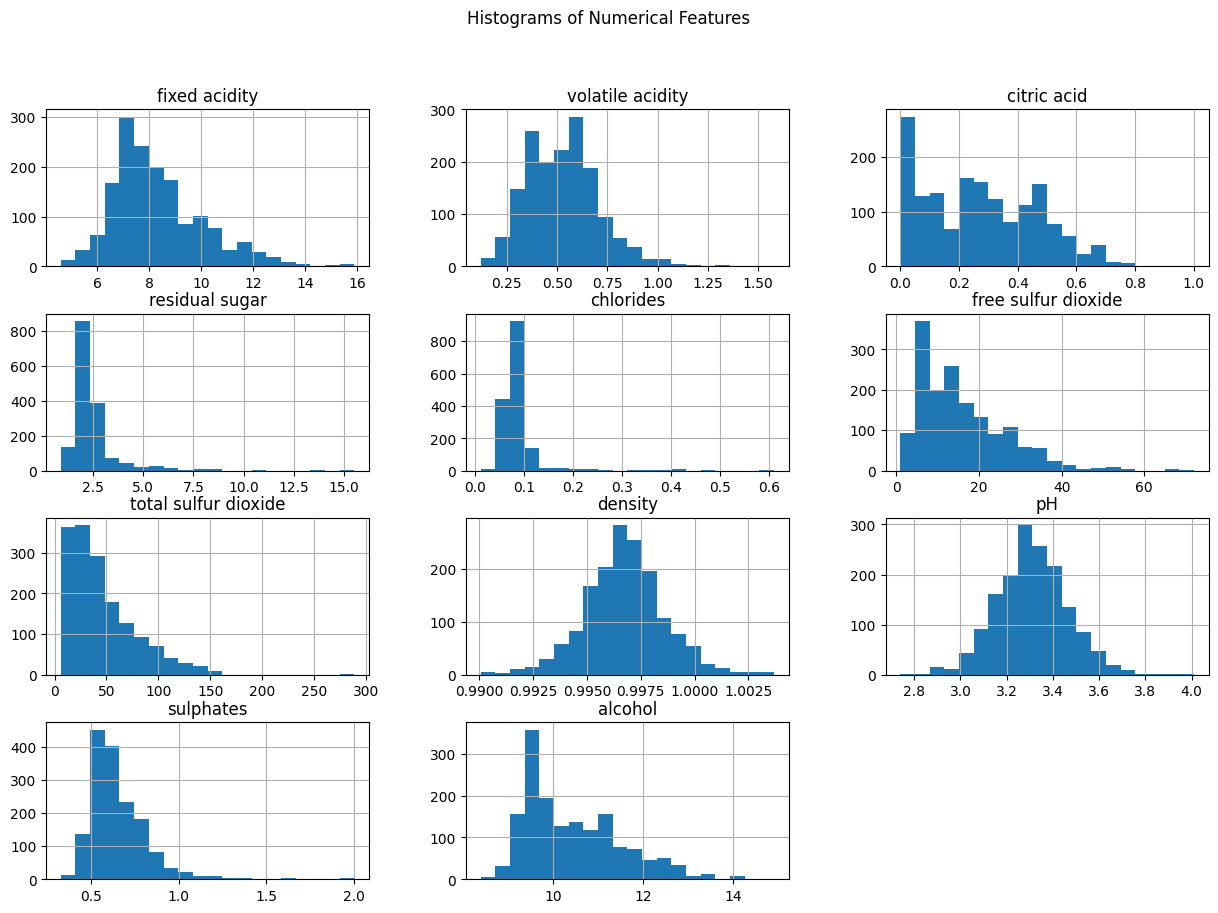

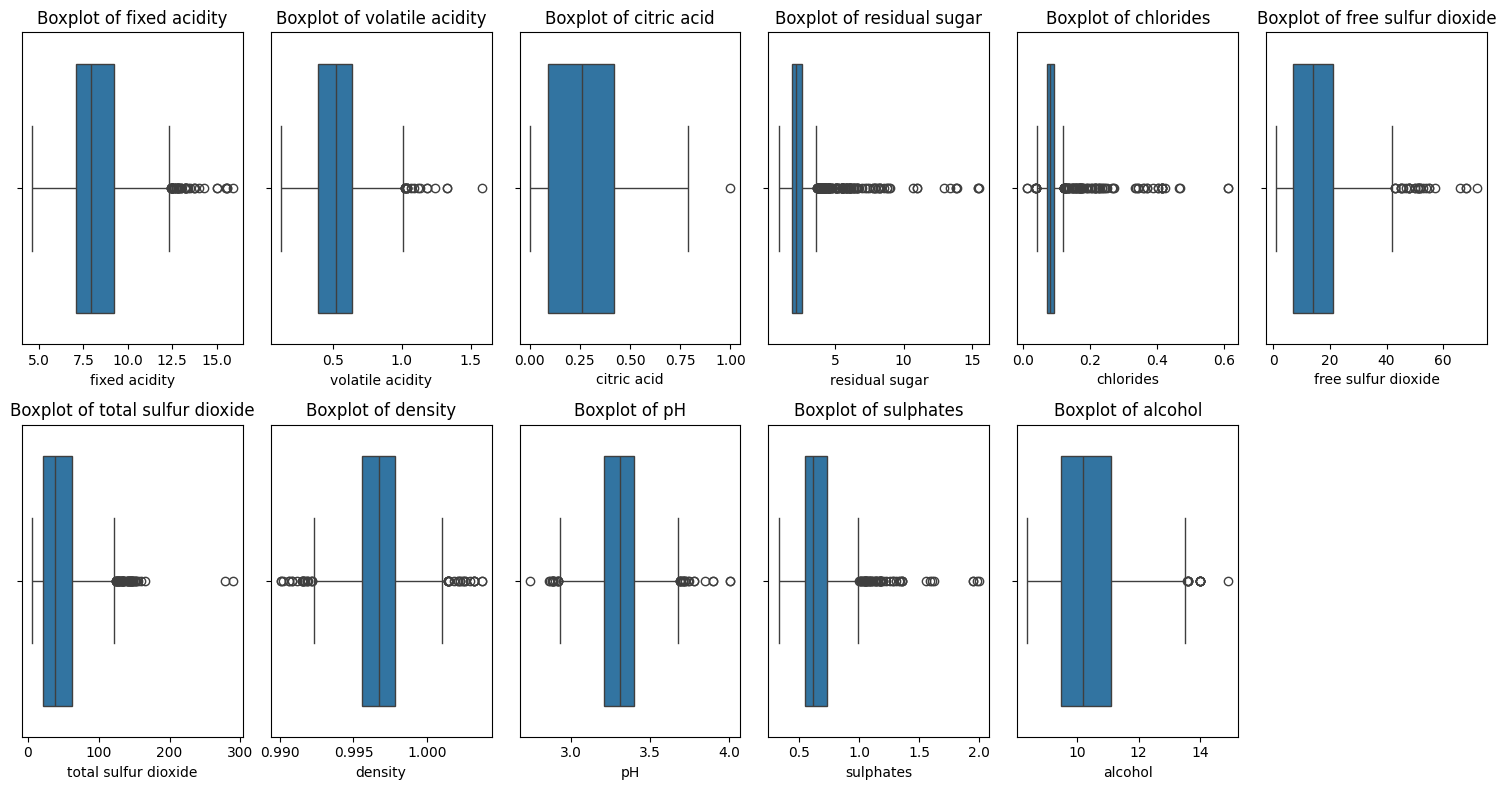

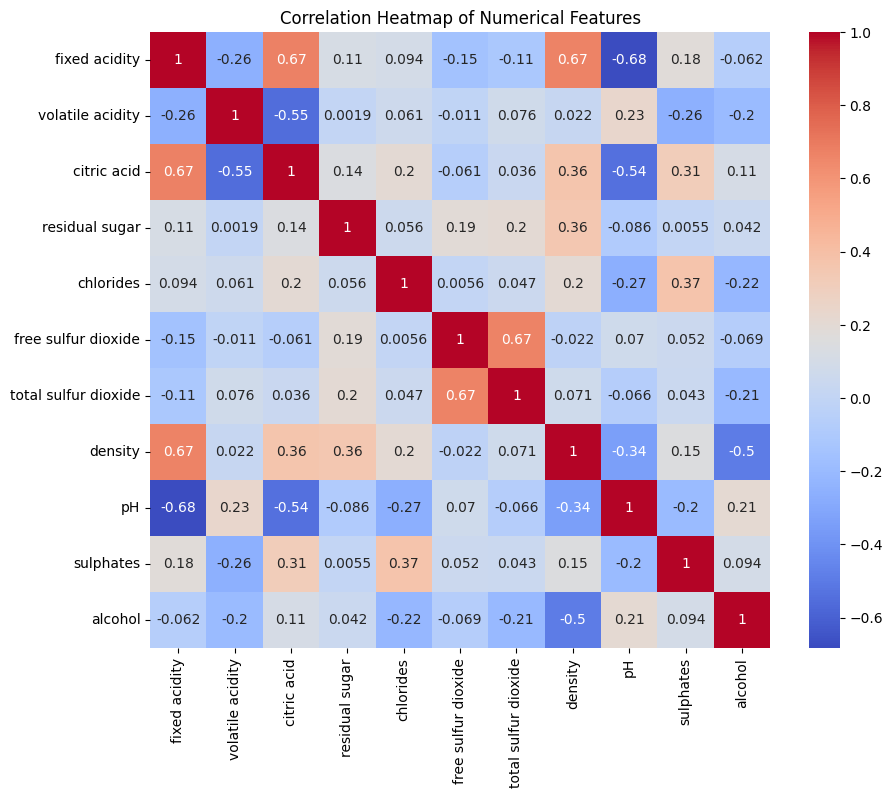


=== Target Variable Distribution ===
quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


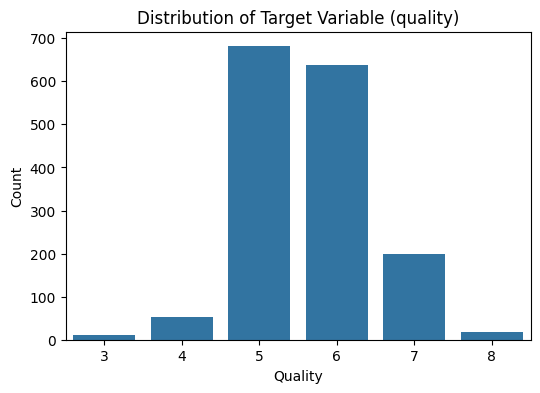

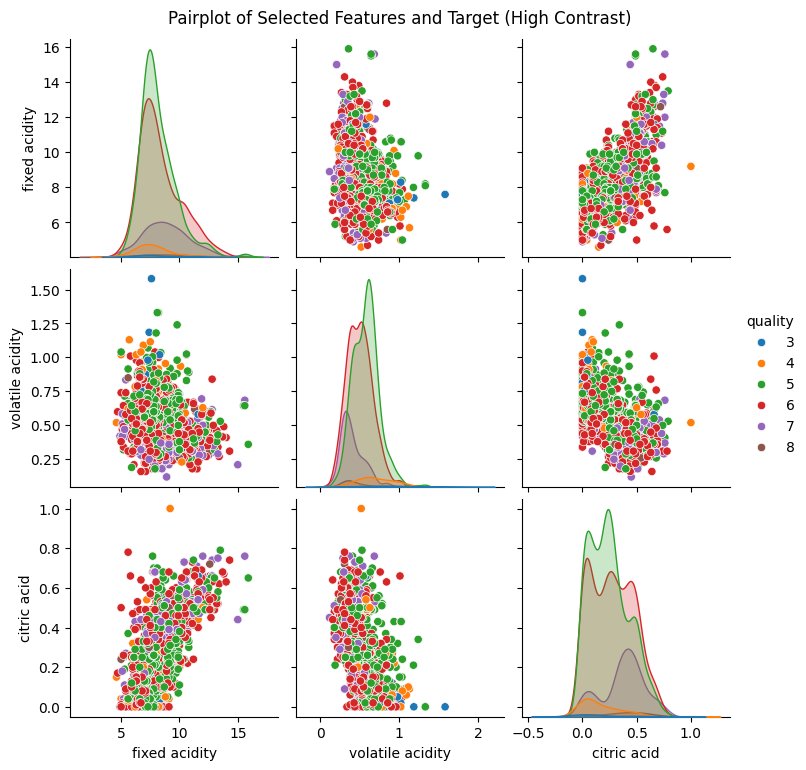

In [34]:
# Prompt: Provide a complete Exploratory data analysis for the X features and the target variable
# EDA for X features and target variable y

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic info and missing values
print("=== Data Info ===")
print(X.info())
print("\n=== Missing Values ===")
print(X.isnull().sum())

# 2. Summary statistics for numerical features
print("\n=== Summary Statistics (Numerical) ===")
print(X.describe())

# 3. Value counts for categorical features
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"\n=== Value Counts for {col} ===")
    print(X[col].value_counts())

# 4. Distribution plots for numerical features
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Histograms of Numerical Features")
plt.show()

# 5. Boxplots for numerical features
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, (len(num_cols)+1)//2, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# 7. Target variable distribution
print("\n=== Target Variable Distribution ===")
print(y.value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribution of Target Variable (quality)")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

# 8. Pairplot for selected features and target
# selected_cols = list(num_cols[:3]) + ['alcohol_level']
# sns.pairplot(pd.concat([X[selected_cols], y], axis=1), hue='quality', diag_kind='kde')
# plt.suptitle("Pairplot of Selected Features and Target", y=1.02)
# plt.show()


# Select columns for the pairplot
selected_cols = list(X.select_dtypes(include=['float64', 'int64']).columns[:3]) + ['alcohol_level']
data_for_pairplot = pd.concat([X[selected_cols], y.rename('quality')], axis=1)

# Use a high-contrast palette for 7 classes
sns.pairplot(
    data_for_pairplot,
    hue='quality',
    diag_kind='kde',
    palette=sns.color_palette('tab10', n_colors=6)
)
plt.suptitle("Pairplot of Selected Features and Target (High Contrast)", y=1.02)
plt.show()

In [12]:
# Define preprocessing options
preprocessors = {
    'standard': ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.select_dtypes(include=['float64']).columns.tolist()),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['alcohol_level'])
        ]),
    'minmax': ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), X.select_dtypes(include=['float64']).columns.tolist()),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['alcohol_level'])
        ]),
    'robust': ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), X.select_dtypes(include=['float64']).columns.tolist()),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['alcohol_level'])
        ])
}

In [13]:
# MODEL TRAINING & SELECTION

def train_and_select_model(X_train, y_train, preprocessors, config):
    models = {
        "RandomForest": (RandomForestClassifier(), config["hyperparameters"]["RandomForest"]),
        "KNN": (KNeighborsClassifier(), config["hyperparameters"]["KNN"]),
        "SVM": (SVC(probability=True), config["hyperparameters"]["SVM"]),
        "LogisticRegression": (LogisticRegression(), config["hyperparameters"]["LogisticRegression"])
    }

    best_model = None
    best_score = -np.inf
    model_results = []

    for name, (model, params) in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', None),
            ('classifier', model)
        ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid={
                'preprocessor': list(preprocessors.values()),
                **{'classifier__' + key: value for key, value in params.items()}
            },
            scoring=config["metrics"],
            refit=config["metrics"][0],
            cv=5,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        # Store results
        model_results.append({
            'model': name,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'metrics': {
                metric: grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]
                for metric in config["metrics"]
            }
        })

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = grid_search.best_estimator_

    return best_model, model_results

In [ ]:
# MAIN EXECUTION

if __name__ == "__main__":
    # Load and preprocess data
    df, X, y  = load_and_enrich_data(CONFIG)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=CONFIG["test_size"],
        random_state=CONFIG["random_state"],
        stratify=y
    )

    # Train and select the best model
    best_model, model_results = train_and_select_model(
        X_train,
        y_train,
        preprocessors,
        CONFIG)

    # Final evaluation
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    final_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average='macro'),
        "roc_auc_ovr": roc_auc_score(y_test, y_proba, multi_class='ovr')
    }


    # Extract preprocessor information
    best_preprocessor_type = None
    for _, transformer, _ in best_model.named_steps['preprocessor'].transformers:
        if isinstance(transformer, (StandardScaler, MinMaxScaler, RobustScaler)):
            best_preprocessor_type = type(transformer).__name__
            break

    print("=== Training Complete ===")
    print(f"Best Model: {type(best_model.named_steps['classifier']).__name__}")
    print("Test Metrics:", final_metrics)
    print(f"Best Preprocessor: {best_preprocessor_type}")

=== Training Complete ===
Best Model: RandomForestClassifier
Test Metrics: {'accuracy': 0.659375, 'f1_macro': 0.39183535901721656, 'roc_auc_ovr': 0.8029811592935648}
Best Preprocessor: StandardScaler


In [15]:
print("Storing model artifacts.")
os.makedirs(CONFIG["storage_path"], exist_ok=True)

dump(best_model, os.path.join(CONFIG["storage_path"], 'best_model.joblib'))

Storing model artifacts.


['model_artifacts/best_model.joblib']

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

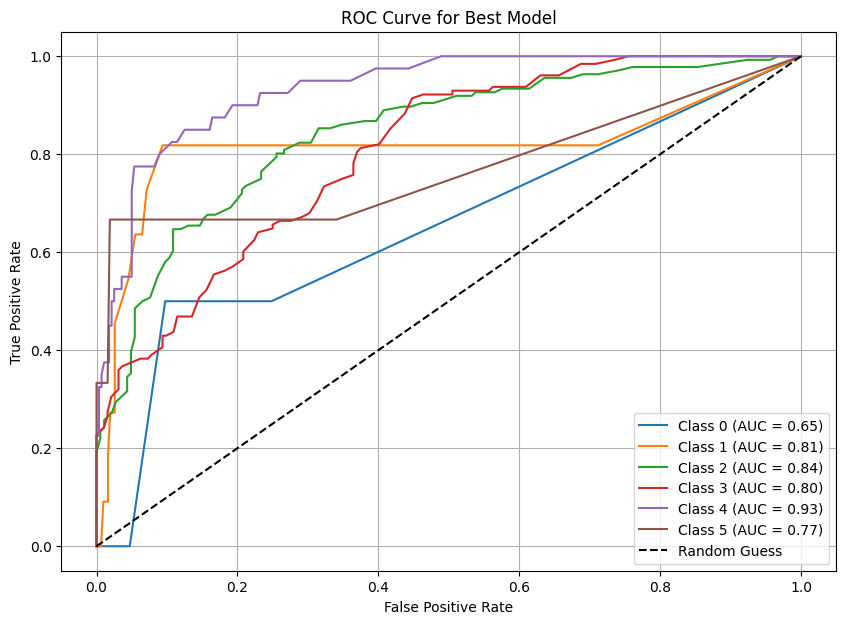

In [16]:

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities
y_score = best_model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Add labels and legend
plt.title("ROC Curve for Best Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The roc_auc_ovr (Receiver Operating Characteristic - Area Under the Curve for One-vs-Rest) metric evaluates the performance of a multi-class classification model. It calculates the AUC for each class against all other classes (one-vs-rest) and averages the results. A higher value (closer to 1) indicates better model performance in distinguishing between classes.